# Training an LSTM NN

### Modelling strategy

I have decided to break the model architecture down into two parts: 
1. The first part should predict UPDRS at time horizon $t=0$ from the peptide features
2. The second will predict the time progression of the UPDRS, based on the output from the first model.

The advantage of breaking the model into two steps is that we can use much more patient UPDRS data for the second prediction step, since we have many data that are not linked to peptide measurements.

In [1]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt

import pandas as pd
import numpy as np
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')


In [2]:

# eye candy plots
plt.style.use('https://github.com/dhaitz/matplotlib-stylesheets/raw/master/pitayasmoothie-dark.mplstyle')

In [3]:
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras.layers.experimental import preprocessing
import tensorflow.keras.models as models
import tensorflow.keras.layers as layers
from tensorflow.keras.layers import Dense, LSTM

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, TimeDistributed

print(tf.__version__)

2023-05-10 18:20:22.651616: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


No supported GPU was found.
2.12.0


### Import data and pre-process

In [4]:
df_X = pd.read_csv('data/features_matrix.csv')
df_X

,visit_id,patient_id,visit_month,AAFGQGSGPIMLDEVQC(UniMod_4)TGTEASLADC(UniMod_4)K,AANEVSSADVK,AATGEC(UniMod_4)TATVGKR,AATVGSLAGQPLQER,ADDLGKGGNEESTKTGNAGSR,ADQVC(UniMod_4)INLR,ADRDQYELLC(UniMod_4)LDNTR,...,VKSPELQAEAK,VLEPTLK,VLTPTQVK,VTGVVLFR,VTIKPAPETEKRPQDAK,VYAC(UniMod_4)EVTHQGLSSPVTK,WSGQTAIC(UniMod_4)DNGAGYC(UniMod_4)SNPGIPIGTR,YLYEIAR,YTTEIIK,YYC(UniMod_4)FQGNQFLR
0,55_0,55,0,53855.6,NaN,19735.4,114400.0,39389.3,316108.0,391564.0,...,0,0,0,0,0,0,0,0,0,0
1,55_6,55,6,45251.9,49927.5,23820.4,90539.4,40871.1,275766.0,431155.0,...,0,0,0,0,0,0,0,0,0,0
2,55_12,55,12,53000.9,45519.2,17813.5,147312.0,35002.7,317887.0,471799.0,...,0,0,0,0,0,0,0,0,0,0
3,55_36,55,36,58108.4,52374.0,19373.3,64356.1,44147.9,325403.0,458131.0,...,0,0,0,0,0,0,0,0,0,0
4,942_6,942,6,42682.6,25698.8,17130.6,86471.5,22944.8,134594.0,474617.0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
563,64674_48,64674,48,31434.3,11667.5,10309.1,12677.8,NaN,101673.0,352584.0,...,0,0,1,0,0,0,0,0,0,0
564,65043_0,65043,0,95033.0,57483.7,11610.0,270739.0,46225.1,309464.0,446825.0,...,0,0,1,0,0,0,0,0,0,0
565,65043_12,65043,12,76532.7,54260.6,11631.9,230169.0,43775.4,300912.0,455039.0,...,0,0,1,0,0,0,0,0,0,0
566,65043_24,65043,24,75401.6,NaN,13313.9,220202.0,30188.3,334504.0,543121.0,...,0,0,1,0,0,0,0,0,0,0


In [5]:
df_y = pd.read_csv('data/target_matrix.csv')
df_y

,visit_id,patient_id,visit_month,updrs_1,updrs_2,updrs_3,updrs_4
0,55_0,55,0,10.0,6.0,15.0,0.0
1,55_6,55,6,8.0,10.0,34.0,0.0
2,55_12,55,12,10.0,10.0,41.0,0.0
3,55_18,55,18,7.0,13.0,38.0,0.0
4,55_24,55,24,16.0,9.0,49.0,0.0
...,...,...,...,...,...,...,...
1503,65043_36,65043,36,2.0,7.0,5.0,0.0
1504,65043_48,65043,48,7.0,6.0,13.0,0.0
1505,65043_54,65043,54,4.0,8.0,11.0,1.0
1506,65043_60,65043,60,6.0,6.0,16.0,1.0


Reshape target variable so that each feature sample has a prediction window of 4 timesteps, like
$t + (0,6,12,24)$

In [6]:
time_steps = np.array([0,6,12,24])
yy = []   # target (samples, month, updrs)

for patient in df_X.patient_id.unique():
    yy_patient = df_y.query("patient_id == @patient").set_index("visit_month")
    for visit in df_X[df_X.patient_id == patient].visit_month:
        new_sample = yy_patient.loc[list(time_steps+ visit)]
        new_line = new_sample[['updrs_1','updrs_2','updrs_3','updrs_4']].to_numpy()
        new_meta = np.array([patient,visit])
        
        yy.append(new_line)
        
yy = np.array(yy)

print("yy shape (samples, 4*target timestep, 4*target values): \n", yy.shape)
print("df_X shape (samples, 2*metadata + 582*features): \n",df_X.shape)

yy shape (samples, 4*target timestep, 4*target values): 
 (568, 4, 4)
df_X shape (samples, 2*metadata + 582*features): 
 (568, 586)


Test train split, before scaling. Then scale using Min-Max.

In [33]:
X_train, X_test, y_train, y_test = train_test_split(df_X, yy, test_size=0.2, random_state=12)

### Drop meta data from features matrix
meta_names = ['visit_id','patient_id','visit_month']

# Train
meta_train = X_train[meta_names].copy() 
X_train = X_train.drop(meta_names, axis=1)

# Test
meta_test = X_test[meta_names].copy() 
X_test = X_test.drop(meta_names, axis=1)

### Scale numeric features


# Get names of features
num_feat_names = pd.read_csv('data/numeric_peptide_features.csv',header=None).values.flatten()
bin_feat_names = pd.read_csv('data/binary_peptide_features.csv',header=None).values.flatten()

# Seperate numeric features und take the logarithm
X_train_num = X_train[num_feat_names]
X_test_num = X_test[num_feat_names]
X_train_num = X_train_num.apply(lambda x: np.log(x))
X_test_num = X_test_num.apply(lambda x: np.log(x))

# Scale numeric
scaler = StandardScaler() #MinMaxScaler()

X_train_num_np = pd.DataFrame(scaler.fit_transform(X_train_num)) # fit to train data
X_test_num_np  = pd.DataFrame(scaler.transform(X_test_num)) # only tranform test data, no data leakage

# Mask missing valaues
X_train_num_np.fillna(-1,inplace=True)
X_test_num_np.fillna(-1, inplace=True)

# Put features back together again
X_train[num_feat_names] = X_train_num_np.values
X_test[num_feat_names]  = X_test_num_np.values

# 
X_train_np = X_train.to_numpy()
X_test_np = X_test.to_numpy()



In [8]:
#Test using all features

In [11]:
#X_train_np = X_train_np.reshape(-1, 1, 582)
X_train_np.shape

(454, 583)

In [12]:
#X_test_np = X_test_np.reshape(-1, 1, 582)
X_test_np.shape

(114, 583)

In [13]:
y_train.shape

(454, 4, 4)

### Plotting and evaluation functions

In [14]:
## Ploting results

def plot_results_0(preds, y_test):
    preds_df = pd.DataFrame(preds, columns=['updrs_1','updrs_2','updrs_3', 'updrs_4']).round()
    preds_df = preds_df.melt().rename(columns={'value': 'predictions'})
    test_df  = pd.DataFrame(y_test[:,0,:], columns=['updrs_1','updrs_2','updrs_3', 'updrs_4'])
    test_df = test_df.melt().rename(columns={'value': 'actual'})

    data_plot = preds_df.merge(test_df.drop('variable',axis=1), left_index=True, right_index=True)

    g = sns.FacetGrid(data_plot, col="variable", sharex=False, sharey=False)
    g.map(sns.scatterplot,'predictions', 'actual')
    
## smape evaluation metric
def smape(predictions, actual):
    P = np.round(predictions) + 1
    A = actual  + 1
    return 100/len(A) * np.sum(2 * np.abs(P - A) / (np.abs(A) + np.abs(P)))


## Plotting function for model loss and validation loss... write as next step
# plt.plot(smod_history.history['loss'])
# plt.plot(smod_history.history['val_loss'])
# plt.title('model loss')
# plt.ylabel('mse')
# plt.xlabel('epoch')
# plt.legend(['train', 'val'], loc='upper left')
# plt.show()

## Model architecture

In [15]:
X_test_np.shape

(114, 583)

In [16]:
n_features = X_test_np.shape[1]
n_time = 4
n_targets = 4

## Baseline for model part 1

This baseline model is under-fitted and outputs (almost always) the same mean value. It achieves a smape of 242.

In [49]:
# First model

model1_base = keras.Sequential([
        layers.Masking(mask_value=-1, input_shape=(n_features,)),
        layers.Dense(64, activation='linear'),
        layers.Dense(n_targets, activation='relu'), # Using a relu layer to ensure that values are > 0.
    ])

model1_base.compile(optimizer='adam', loss='mse')
model1_base.summary()

mod_history = model1_base.fit(X_train_np, y_train[:,0,:],
          validation_split=0.2,
          epochs=20,
)
preds = model1_base.predict(X_test_np)

# # Second model
# input_layer2 = layers.Input(shape=(n_targets,))
# repeated_output2 = layers.RepeatVector(n_time)(input_layer2)
# lstm_layer2 = layers.LSTM(50, return_sequences=True)(repeated_output2)
# output_layer2 = layers.TimeDistributed(layers.Dense(1))(lstm_layer2)
# model2 = models.Model(inputs=input_layer2, outputs=output_layer2)
# model2.compile(optimizer='adam', loss='mse')
# model2.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 masking_2 (Masking)         (None, 583)               0         
                                                                 
 dense_11 (Dense)            (None, 64)                37376     
                                                                 
 dense_12 (Dense)            (None, 4)                 260       
                                                                 
Total params: 37,636
Trainable params: 37,636
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
12/12 [==============================] - 1s 28ms/step - loss: 161.7777 - val_loss: 147.5069
Epoch 2/20
12/12 [==============================] - 0s 6ms/step - loss: 134.6053 - val_loss: 134.6715
Epoch 3/20
12/12 [==============================] - 0s 7ms/step - loss: 117.4402 - val_loss: 112.9192
Epoch 4

226.36862131573935


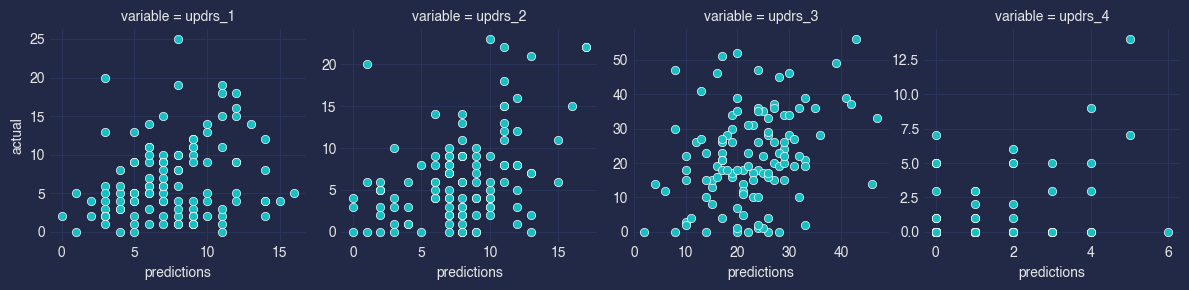

In [50]:
plot_results_0(preds, y_test)
print(smape(y_test[:,0,:], preds))

### A NN with more layers and nodes

In [19]:
## A second model


model1_A = keras.Sequential([
        layers.Masking(mask_value=-1, input_shape=(n_features,)),
        layers.Dense(1500, activation='relu'),
        tf.keras.layers.Dropout(0.4),
        layers.Dense(1500, activation='relu'),
        tf.keras.layers.Dropout(0.4),
        layers.Dense(1500, activation='relu'),
        tf.keras.layers.Dropout(0.4),
        layers.Dense(n_targets, activation='relu'), # Using a relu layer to ensure that values are > 0.
    ])

model1_A.compile(optimizer='adam', loss='mse')
model1_A.summary()

mod_history = model1_A.fit(X_train_np, y_train[:,0,:],
          validation_split=0.2,
          epochs=20,
)
preds = model1_A.predict(X_test_np)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 masking_1 (Masking)         (None, 583)               0         
                                                                 
 dense_2 (Dense)             (None, 1500)              876000    
                                                                 
 dropout (Dropout)           (None, 1500)              0         
                                                                 
 dense_3 (Dense)             (None, 1500)              2251500   
                                                                 
 dropout_1 (Dropout)         (None, 1500)              0         
                                                                 
 dense_4 (Dense)             (None, 1500)              2251500   
                                                                 
 dropout_2 (Dropout)         (None, 1500)             

191.79602825804528


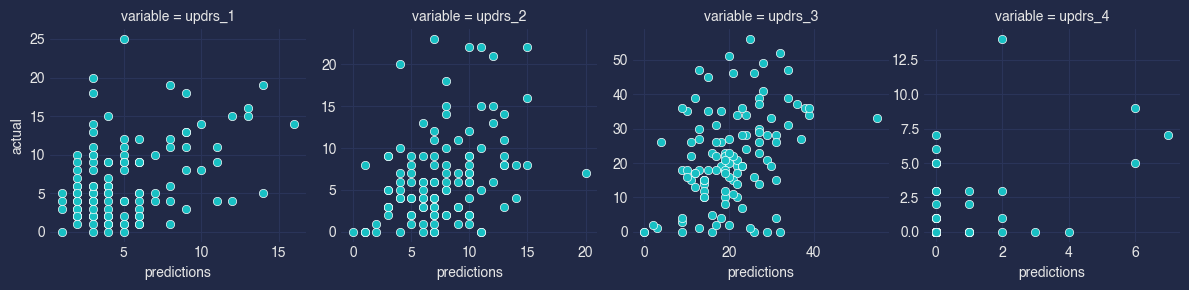

In [20]:
plot_results_0(preds, y_test)
print(smape(y_test[:,0,:], preds))

### Improvements with PCA?

In [21]:
# Try with PCA

from sklearn.decomposition import PCA
n_components = 10
pca = PCA(n_components=n_components)
X_train_pca = pca.fit_transform(X_train_np)
X_test_pca = pca.transform(X_test_np)


# PCA model

model1_PCA = keras.Sequential([
        layers.Input(shape=(n_components,)),
        layers.Dense(2400, activation='relu'),
        tf.keras.layers.Dropout(0.2),
        layers.Dense(512, activation='relu'),
        tf.keras.layers.Dropout(0.2),
        layers.Dense(512, activation='relu'),
        tf.keras.layers.Dropout(0.2),
        layers.Dense(512, activation='relu'),
        tf.keras.layers.Dropout(0.2),
        layers.Dense(n_targets, activation='relu'), # Using a relu layer to ensure that values are > 0.
    ])

model1_PCA.compile(optimizer='adam', loss='mse')
model1_PCA.summary()

mod_history = model1_PCA.fit(X_train_pca, y_train[:,0,:],
          validation_split=0.2,
          epochs=15,
)
preds = model1_PCA.predict(X_test_pca)


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 2400)              26400     
                                                                 
 dropout_3 (Dropout)         (None, 2400)              0         
                                                                 
 dense_7 (Dense)             (None, 512)               1229312   
                                                                 
 dropout_4 (Dropout)         (None, 512)               0         
                                                                 
 dense_8 (Dense)             (None, 512)               262656    
                                                                 
 dropout_5 (Dropout)         (None, 512)               0         
                                                                 
 dense_9 (Dense)             (None, 512)              

204.91958104878134


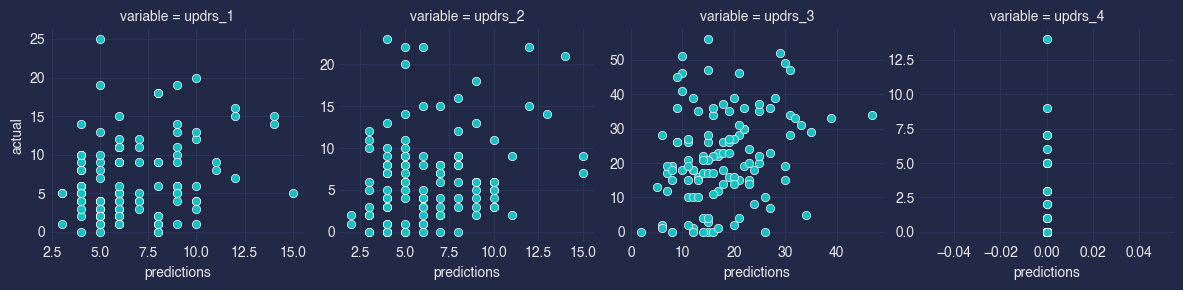

In [22]:
plot_results_0(preds, y_test)
print(smape(y_test[:,0,:], preds))

,AAFGQGSGPIMLDEVQC(UniMod_4)TGTEASLADC(UniMod_4)K,AANEVSSADVK,AATGEC(UniMod_4)TATVGKR,AATVGSLAGQPLQER,ADDLGKGGNEESTKTGNAGSR,ADQVC(UniMod_4)INLR,ADRDQYELLC(UniMod_4)LDNTR,ADSGEGDFLAEGGGVR,AEAQEAEDQQAR,AEFAEVSK,...,VKSPELQAEAK,VLEPTLK,VLTPTQVK,VTGVVLFR,VTIKPAPETEKRPQDAK,VYAC(UniMod_4)EVTHQGLSSPVTK,WSGQTAIC(UniMod_4)DNGAGYC(UniMod_4)SNPGIPIGTR,YLYEIAR,YTTEIIK,YYC(UniMod_4)FQGNQFLR
555,-0.358342,0.412158,NaN,0.249805,NaN,-0.151489,-0.145842,-0.344790,NaN,0.222299,...,0,0,1,0,0,0,0,0,0,0
270,0.193866,0.873103,0.422497,-0.482445,0.731045,-0.540007,0.112602,-0.803653,-1.883934,1.325040,...,0,0,1,0,0,0,1,0,0,0
61,-0.377566,-0.250256,0.172186,-0.271268,-0.853758,-0.556291,-0.031051,NaN,0.064997,0.505736,...,0,0,1,0,0,0,0,0,0,0
257,-0.414972,0.728721,NaN,0.221978,0.251950,0.273091,0.020659,-0.360859,0.948213,1.726065,...,0,0,0,0,0,0,0,0,0,0
535,0.405009,0.529165,0.023662,0.185889,NaN,-0.160613,0.434740,-0.950854,NaN,-0.577115,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
432,0.066474,0.715479,-0.610050,0.365979,0.258365,0.290278,0.712315,0.208708,0.260467,0.280500,...,0,0,0,0,0,0,0,0,0,0
259,-1.928272,-0.187950,0.733392,-0.155162,-0.542753,0.266089,0.637160,-0.310210,-0.073706,-0.302002,...,0,0,1,0,0,0,0,0,0,0
241,NaN,0.015689,0.342158,-0.490138,-0.596859,-0.150600,1.183471,1.879193,-0.325882,1.944371,...,0,0,1,0,0,0,0,0,0,0
253,-0.285148,-0.663133,-4.383691,0.333181,-1.184228,0.414897,0.871099,0.969324,-0.223635,1.753598,...,0,0,0,0,0,0,0,0,0,0


### A Decision Forest Regressor

In [43]:
import tensorflow_decision_forests as tfdf

## We have to feed the data differently
data_train = X_train.copy()
data_train[data_train == -1] = np.nan
data_test = X_test.copy()
data_test[data_test == -1] = np.nan

preds_ = np.zeros_like(y_test[:,:1,:])

tree_models = []

for updrs in range(4):
    data_train['updrs'] = y_train[:,0,updrs]
    data_test['updrs']  = y_test[:,0,updrs]
    
    train_ds = tfdf.keras.pd_dataframe_to_tf_dataset(data_train, label='updrs', task=tfdf.keras.Task.REGRESSION)
    test_ds = tfdf.keras.pd_dataframe_to_tf_dataset(data_test, label='updrs', task=tfdf.keras.Task.REGRESSION)

    model1_Tree = tfdf.keras.RandomForestModel(task=tfdf.keras.Task.REGRESSION)
    model1_Tree.compile(metrics='mse')
    
    
    model1_Tree.fit(train_ds)
    preds = model1_Tree.predict(test_ds) 
    # Save model
    tree_models.append(model1_Tree)
    preds_[:,0,updrs] = preds.flatten()



Use /var/folders/ly/g78z130x68j5xxzvg2j6_skr0000gn/T/tmpzs4pe0ir as temporary training directory
Reading training dataset...


2023-05-10 19:25:31.419621: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_143' with dtype double and shape [454]
	 [[{{node Placeholder/_143}}]]


Training dataset read in 0:00:06.928714. Found 454 examples.
Training model...
Model trained in 0:00:04.207984
Compiling model...


[INFO 23-05-10 19:25:42.3344 CEST kernel.cc:1242] Loading model from path /var/folders/ly/g78z130x68j5xxzvg2j6_skr0000gn/T/tmpzs4pe0ir/model/ with prefix 542123f9a2ff4922
[INFO 23-05-10 19:25:42.4459 CEST decision_forest.cc:660] Model loaded with 300 root(s), 42296 node(s), and 537 input feature(s).
[INFO 23-05-10 19:25:42.4459 CEST abstract_model.cc:1312] Engine "RandomForestOptPred" built
[INFO 23-05-10 19:25:42.4461 CEST kernel.cc:1074] Use fast generic engine
2023-05-10 19:25:42.515041: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_9' with dtype double and shape [454]
	 [[{{node Placeholder/_9}}]]


Model compiled.


2023-05-10 19:25:46.571191: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_182' with dtype int64 and shape [114]
	 [[{{node Placeholder/_182}}]]


1/1 [==============================] - 1s 945ms/step
Use /var/folders/ly/g78z130x68j5xxzvg2j6_skr0000gn/T/tmph1s5hbbk as temporary training directory
Reading training dataset...


2023-05-10 19:25:48.426077: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_80' with dtype double and shape [454]
	 [[{{node Placeholder/_80}}]]


Training dataset read in 0:00:06.086660. Found 454 examples.
Training model...
Model trained in 0:00:04.235554
Compiling model...


[INFO 23-05-10 19:25:58.5832 CEST kernel.cc:1242] Loading model from path /var/folders/ly/g78z130x68j5xxzvg2j6_skr0000gn/T/tmph1s5hbbk/model/ with prefix 7c93a9866b094a1f
[INFO 23-05-10 19:25:58.6913 CEST decision_forest.cc:660] Model loaded with 300 root(s), 41342 node(s), and 531 input feature(s).
[INFO 23-05-10 19:25:58.6914 CEST abstract_model.cc:1312] Engine "RandomForestOptPred" built
[INFO 23-05-10 19:25:58.6916 CEST kernel.cc:1074] Use fast generic engine
2023-05-10 19:25:58.756278: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_262' with dtype double and shape [454]
	 [[{{node Placeholder/_262}}]]


Model compiled.


2023-05-10 19:26:02.287950: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_409' with dtype double and shape [114]
	 [[{{node Placeholder/_409}}]]


1/1 [==============================] - 1s 1s/step
Use /var/folders/ly/g78z130x68j5xxzvg2j6_skr0000gn/T/tmpjsc324or as temporary training directory
Reading training dataset...


2023-05-10 19:26:04.699422: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_26' with dtype double and shape [454]
	 [[{{node Placeholder/_26}}]]


Training dataset read in 0:00:06.552188. Found 454 examples.
Training model...
Model trained in 0:00:04.611156
Compiling model...


[INFO 23-05-10 19:26:15.7011 CEST kernel.cc:1242] Loading model from path /var/folders/ly/g78z130x68j5xxzvg2j6_skr0000gn/T/tmpjsc324or/model/ with prefix 948986d05ecb466b
[INFO 23-05-10 19:26:15.8082 CEST decision_forest.cc:660] Model loaded with 300 root(s), 41722 node(s), and 517 input feature(s).
[INFO 23-05-10 19:26:15.8084 CEST abstract_model.cc:1312] Engine "RandomForestOptPred" built
[INFO 23-05-10 19:26:15.8086 CEST kernel.cc:1074] Use fast generic engine
2023-05-10 19:26:15.873089: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_92' with dtype int64 and shape [454]
	 [[{{node Placeholder/_92}}]]


Model compiled.


2023-05-10 19:26:19.882031: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_230' with dtype double and shape [114]
	 [[{{node Placeholder/_230}}]]


1/1 [==============================] - 1s 818ms/step
Use /var/folders/ly/g78z130x68j5xxzvg2j6_skr0000gn/T/tmpmof_yxbo as temporary training directory
Reading training dataset...


2023-05-10 19:26:21.636234: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_400' with dtype int64 and shape [454]
	 [[{{node Placeholder/_400}}]]


Training dataset read in 0:00:06.195173. Found 454 examples.
Training model...
Model trained in 0:00:04.579190
Compiling model...


[INFO 23-05-10 19:26:32.3056 CEST kernel.cc:1242] Loading model from path /var/folders/ly/g78z130x68j5xxzvg2j6_skr0000gn/T/tmpmof_yxbo/model/ with prefix 6ea545c623f64d0c
[INFO 23-05-10 19:26:32.3615 CEST decision_forest.cc:660] Model loaded with 300 root(s), 19654 node(s), and 538 input feature(s).
[INFO 23-05-10 19:26:32.3616 CEST abstract_model.cc:1312] Engine "RandomForestOptPred" built
[INFO 23-05-10 19:26:32.3618 CEST kernel.cc:1074] Use fast generic engine
2023-05-10 19:26:32.422843: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_41' with dtype double and shape [454]
	 [[{{node Placeholder/_41}}]]


Model compiled.


2023-05-10 19:26:36.576013: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_98' with dtype int64 and shape [114]
	 [[{{node Placeholder/_98}}]]


1/1 [==============================] - 1s 1s/step


223.4069450228318


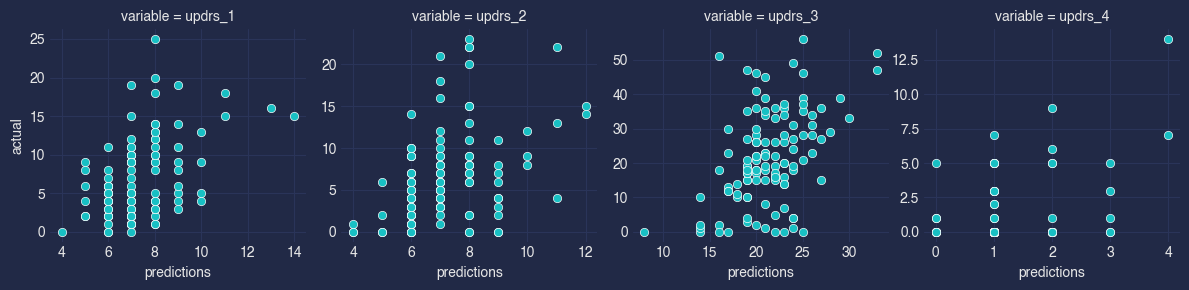

In [47]:
plot_results_0(preds_[:,0,:], y_test)
print(smape(y_test[:,0,:], preds_[:,0,:]))